# Bias-Variance Tradeoff: Finding the Sweet Spot

**Business Question**: How do we choose the right model complexity for predicting house prices?

This notebook demonstrates the fundamental bias-variance tradeoff in machine learning, showing how model complexity affects prediction accuracy and helping you find the optimal balance between underfitting and overfitting.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand what bias and variance mean in machine learning
- Recognize the bias-variance tradeoff and its implications
- Identify underfitting and overfitting in models
- Choose appropriate model complexity for your data
- Use cross-validation to find the optimal model


In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)


## Understanding Bias and Variance

### **Bias**: How far off our model's predictions are from the true values on average
- **High Bias (Underfitting)**: Model is too simple, misses important patterns
- **Low Bias**: Model captures the underlying relationships well

### **Variance**: How much our model's predictions change when trained on different datasets
- **High Variance (Overfitting)**: Model is too complex, memorizes training data
- **Low Variance**: Model is stable across different training sets

### **The Tradeoff**:
- **Simple models**: High bias, low variance (underfitting)
- **Complex models**: Low bias, high variance (overfitting)
- **Goal**: Find the sweet spot with optimal bias-variance balance


## Creating a Realistic Dataset

Let's create a house price dataset with a non-linear relationship to demonstrate the bias-variance tradeoff.


House Price Dataset Created!
Dataset shape: (200, 5)
Price range: $50,000 - $377,590

First 5 rows:
     size_sqft          price  age_years  bedrooms  distance_to_city
0  2123.620357  127946.723906  21.211100         3          3.680681
1  3852.142919  303493.953968  45.317719         3         12.196983
2  3195.981825  294127.754832   5.559874         4          2.254631
3  2795.975453  198229.821616  24.631255         1         11.191184
4  1468.055921  127169.678029   0.567682         1         35.036304


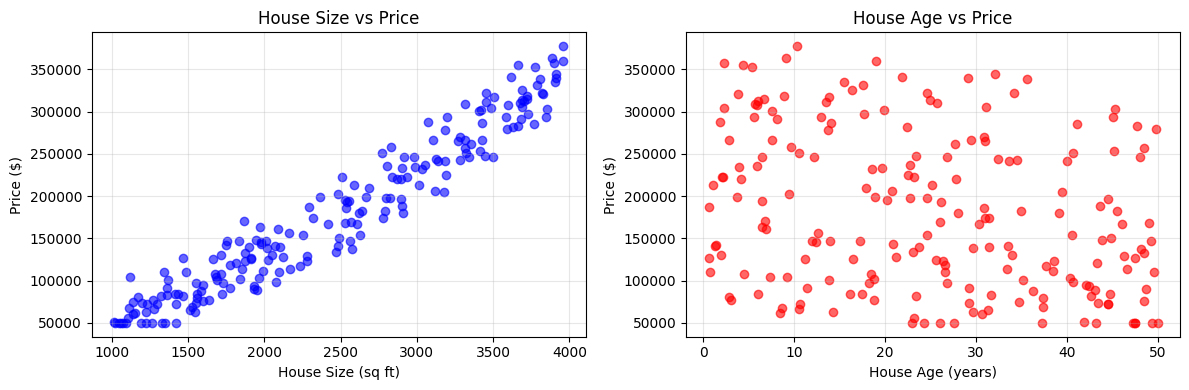

In [2]:
# Create a realistic house price dataset
np.random.seed(42)
n_samples = 200

# Generate house sizes (square feet)
house_size = np.random.uniform(1000, 4000, n_samples)

# Create non-linear relationship with noise
# True relationship: price = 50 * size + 0.01 * size^2 + noise
true_price = 50 * house_size + 0.01 * house_size**2 + np.random.normal(0, 10000, n_samples)

# Create DataFrame
df = pd.DataFrame({
    'size_sqft': house_size,
    'price': true_price
})

# Add some additional features for complexity
df['age_years'] = np.random.uniform(0, 50, n_samples)
df['bedrooms'] = np.random.poisson(3, n_samples)
df['distance_to_city'] = np.random.exponential(10, n_samples)

# Create more complex price relationship
df['price'] = (50 * df['size_sqft'] + 
               0.01 * df['size_sqft']**2 - 
               1000 * df['age_years'] + 
               5000 * df['bedrooms'] - 
               200 * df['distance_to_city'] + 
               np.random.normal(0, 15000, n_samples))

# Ensure positive prices
df['price'] = np.maximum(df['price'], 50000)

print("House Price Dataset Created!")
print(f"Dataset shape: {df.shape}")
print(f"Price range: ${df['price'].min():,.0f} - ${df['price'].max():,.0f}")
print("\nFirst 5 rows:")
print(df.head())

# Visualize the relationship
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(df['size_sqft'], df['price'], alpha=0.6, color='blue')
plt.xlabel('House Size (sq ft)')
plt.ylabel('Price ($)')
plt.title('House Size vs Price')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(df['age_years'], df['price'], alpha=0.6, color='red')
plt.xlabel('House Age (years)')
plt.ylabel('Price ($)')
plt.title('House Age vs Price')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Models of Increasing Complexity

Let's build models with different complexity levels to demonstrate the bias-variance tradeoff.


In [3]:
# Prepare data
X = df[['size_sqft', 'age_years', 'bedrooms', 'distance_to_city']]
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Define models of increasing complexity
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=0.1)': Ridge(alpha=0.1),
    'Ridge (α=0.01)': Ridge(alpha=0.01),
    'Lasso (α=1.0)': Lasso(alpha=1.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
    'Lasso (α=0.01)': Lasso(alpha=0.01)
}

# Train and evaluate models
results = []
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        'Model': name,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'CV MSE': cv_mse,
        'CV Std': cv_std,
        'Overfitting': test_mse - train_mse
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(2)

print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

# Identify best model
best_model_idx = results_df['Test R²'].idxmax()
best_model = results_df.iloc[best_model_idx]

print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"Test R²: {best_model['Test R²']:.3f}")
print(f"Test MSE: ${best_model['Test MSE']:,.0f}")
print(f"Overfitting: ${best_model['Overfitting']:,.0f}")


Training set size: 140
Test set size: 60
MODEL PERFORMANCE COMPARISON
            Model    Train MSE     Test MSE  Train R²  Test R²       CV MSE      CV Std  Overfitting
Linear Regression 269452700.50 244428048.54      0.97     0.97 322786928.90 84574830.57 -25024651.96
    Ridge (α=1.0) 269453029.68 244514869.20      0.97     0.97 322725464.13 84409308.84 -24938160.47
    Ridge (α=0.1) 269452703.81 244436723.57      0.97     0.97 322780713.30 84558203.32 -25015980.23
   Ridge (α=0.01) 269452700.53 244428915.97      0.97     0.97 322786306.65 84573167.09 -25023784.57
    Lasso (α=1.0) 269452700.83 244430650.66      0.97     0.97 322784302.63 84570849.85 -25022050.17
    Lasso (α=0.1) 269452700.50 244428309.37      0.97     0.97 322786665.58 84574432.86 -25024391.14
   Lasso (α=0.01) 269452700.50 244428074.54      0.97     0.97 322786902.60 84574790.74 -25024625.96

🏆 BEST MODEL: Linear Regression
Test R²: 0.970
Test MSE: $244,428,049
Overfitting: $-25,024,652


## Visualizing the Bias-Variance Tradeoff


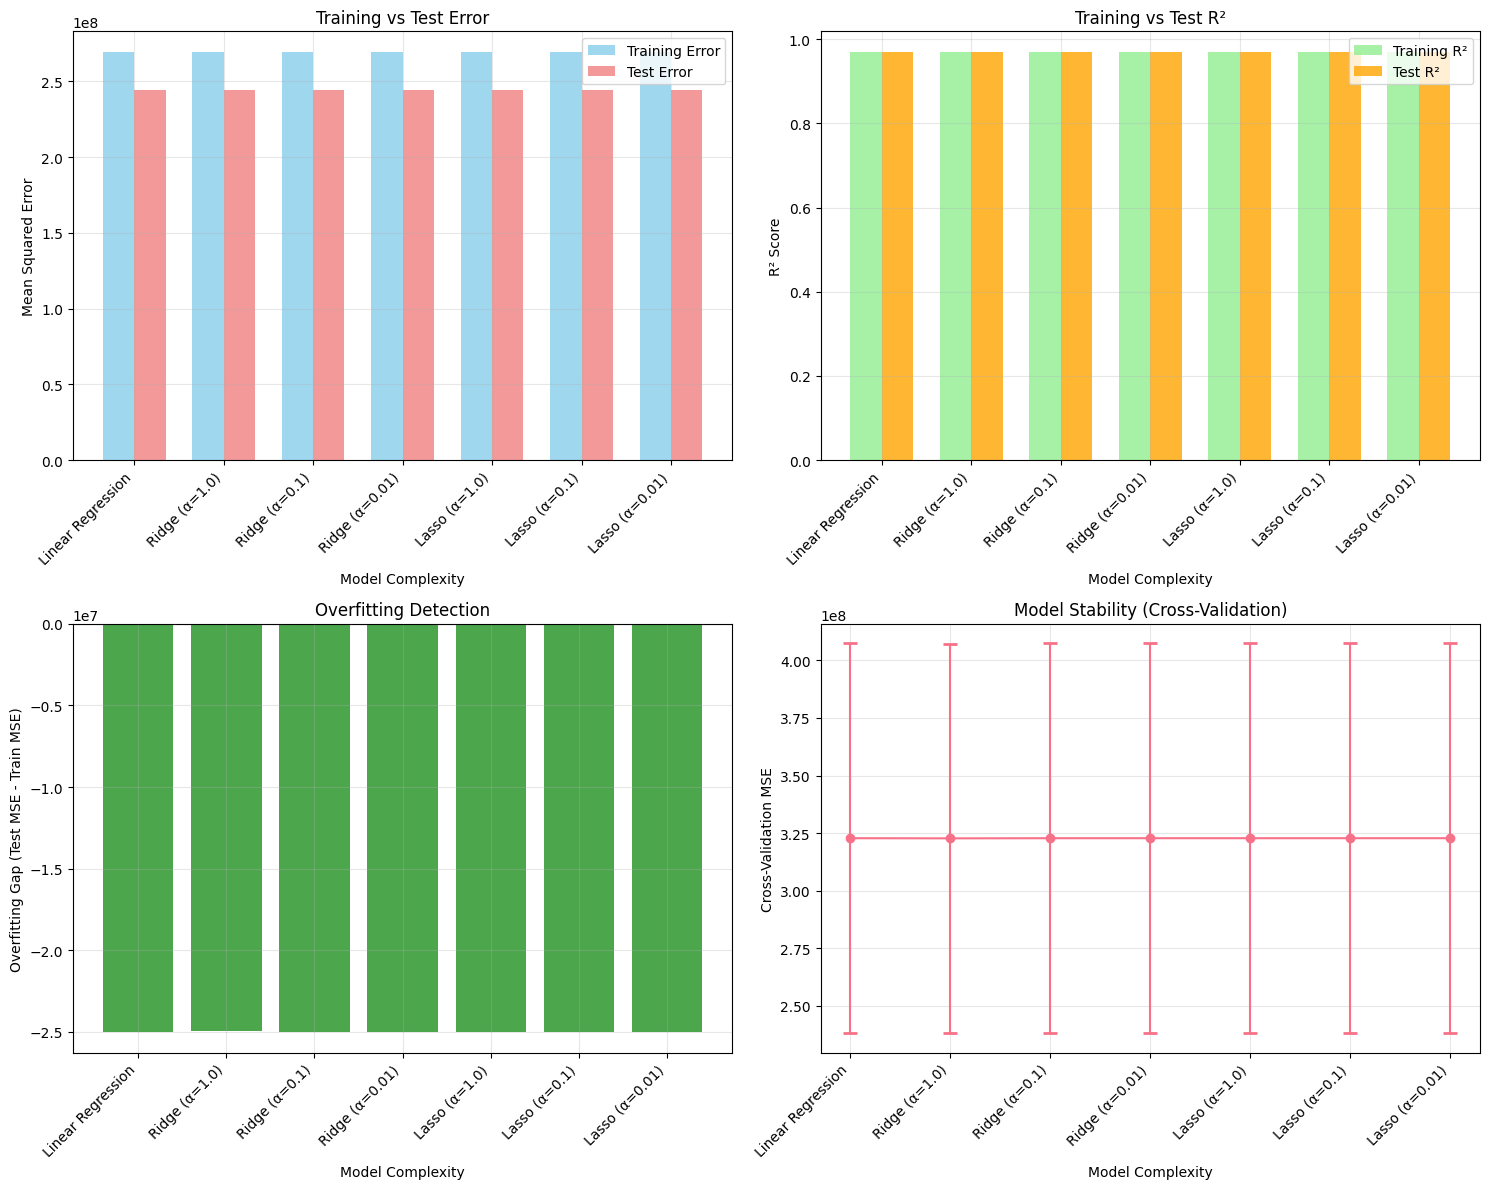

BIAS-VARIANCE ANALYSIS:
🔴 High Bias (Underfitting):

🟡 High Variance (Overfitting):

✅ Good Balance:
  • Linear Regression: R² = 0.970, Gap = $-25,024,652
  • Ridge (α=1.0): R² = 0.970, Gap = $-24,938,160
  • Ridge (α=0.1): R² = 0.970, Gap = $-25,015,980
  • Ridge (α=0.01): R² = 0.970, Gap = $-25,023,785
  • Lasso (α=1.0): R² = 0.970, Gap = $-25,022,050
  • Lasso (α=0.1): R² = 0.970, Gap = $-25,024,391
  • Lasso (α=0.01): R² = 0.970, Gap = $-25,024,626


In [4]:
# Create visualizations of the bias-variance tradeoff
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training vs Test Error
models_list = results_df['Model'].tolist()
train_errors = results_df['Train MSE'].tolist()
test_errors = results_df['Test MSE'].tolist()

x_pos = np.arange(len(models_list))
width = 0.35

axes[0,0].bar(x_pos - width/2, train_errors, width, label='Training Error', alpha=0.8, color='skyblue')
axes[0,0].bar(x_pos + width/2, test_errors, width, label='Test Error', alpha=0.8, color='lightcoral')
axes[0,0].set_xlabel('Model Complexity')
axes[0,0].set_ylabel('Mean Squared Error')
axes[0,0].set_title('Training vs Test Error')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(models_list, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: R² Scores
train_r2 = results_df['Train R²'].tolist()
test_r2 = results_df['Test R²'].tolist()

axes[0,1].bar(x_pos - width/2, train_r2, width, label='Training R²', alpha=0.8, color='lightgreen')
axes[0,1].bar(x_pos + width/2, test_r2, width, label='Test R²', alpha=0.8, color='orange')
axes[0,1].set_xlabel('Model Complexity')
axes[0,1].set_ylabel('R² Score')
axes[0,1].set_title('Training vs Test R²')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(models_list, rotation=45, ha='right')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Overfitting Gap
overfitting = results_df['Overfitting'].tolist()
colors = ['red' if x > 0 else 'green' for x in overfitting]
axes[1,0].bar(x_pos, overfitting, color=colors, alpha=0.7)
axes[1,0].set_xlabel('Model Complexity')
axes[1,0].set_ylabel('Overfitting Gap (Test MSE - Train MSE)')
axes[1,0].set_title('Overfitting Detection')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(models_list, rotation=45, ha='right')
axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Cross-Validation Stability
cv_means = results_df['CV MSE'].tolist()
cv_stds = results_df['CV Std'].tolist()

axes[1,1].errorbar(x_pos, cv_means, yerr=cv_stds, fmt='o-', capsize=5, capthick=2)
axes[1,1].set_xlabel('Model Complexity')
axes[1,1].set_ylabel('Cross-Validation MSE')
axes[1,1].set_title('Model Stability (Cross-Validation)')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(models_list, rotation=45, ha='right')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation
print("BIAS-VARIANCE ANALYSIS:")
print("="*50)
print("🔴 High Bias (Underfitting):")
underfitting_models = results_df[results_df['Test R²'] < 0.5]
if len(underfitting_models) > 0:
    for _, model in underfitting_models.iterrows():
        print(f"  • {model['Model']}: R² = {model['Test R²']:.3f}")

print("\n🟡 High Variance (Overfitting):")
overfitting_models = results_df[results_df['Overfitting'] > 1000000]
if len(overfitting_models) > 0:
    for _, model in overfitting_models.iterrows():
        print(f"  • {model['Model']}: Gap = ${model['Overfitting']:,.0f}")

print("\n✅ Good Balance:")
balanced_models = results_df[(results_df['Test R²'] >= 0.5) & (results_df['Overfitting'] <= 1000000)]
if len(balanced_models) > 0:
    for _, model in balanced_models.iterrows():
        print(f"  • {model['Model']}: R² = {model['Test R²']:.3f}, Gap = ${model['Overfitting']:,.0f}")


## Polynomial Regression: A Classic Example

Let's demonstrate the bias-variance tradeoff using polynomial regression, which clearly shows underfitting and overfitting.


In [5]:
# Create a simple 1D example for polynomial regression
np.random.seed(42)
X_simple = df['size_sqft'].values.reshape(-1, 1)
y_simple = df['price'].values

# Split the data
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple, y_simple, test_size=0.3, random_state=42
)

# Create polynomial models of different degrees
degrees = [1, 2, 3, 4, 5, 6, 7, 8]
poly_results = []

for degree in degrees:
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_simple)
    X_test_poly = poly_features.transform(X_test_simple)
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(X_train_poly, y_train_simple)
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train_simple, y_train_pred)
    test_mse = mean_squared_error(y_test_simple, y_test_pred)
    train_r2 = r2_score(y_train_simple, y_train_pred)
    test_r2 = r2_score(y_test_simple, y_test_pred)
    
    poly_results.append({
        'Degree': degree,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Overfitting': test_mse - train_mse
    })

# Create results DataFrame
poly_df = pd.DataFrame(poly_results)

print("POLYNOMIAL REGRESSION RESULTS")
print("="*60)
print(poly_df.round(2).to_string(index=False))

# Find optimal degree
optimal_idx = poly_df['Test R²'].idxmax()
optimal_degree = poly_df.iloc[optimal_idx]['Degree']

print(f"\n🎯 OPTIMAL DEGREE: {int(optimal_degree)}")
print(f"Test R²: {poly_df.iloc[optimal_idx]['Test R²']:.3f}")
print(f"Overfitting: ${poly_df.iloc[optimal_idx]['Overfitting']:,.0f}")


POLYNOMIAL REGRESSION RESULTS
 Degree    Train MSE     Test MSE  Train R²  Test R²  Overfitting
      1 564072955.38 579032236.21      0.93     0.94  14959280.83
      2 503900104.47 495541928.85      0.94     0.95  -8358175.62
      3 503250380.78 498451139.07      0.94     0.95  -4799241.71
      4 503059651.65 500551242.43      0.94     0.95  -2508409.22
      5 502970161.07 502106164.29      0.94     0.95   -863996.78
      6 503594922.46 504023058.53      0.94     0.95    428136.06
      7 506416248.49 508271776.05      0.94     0.94   1855527.56
      8 514015167.14 518063569.35      0.94     0.94   4048402.21

🎯 OPTIMAL DEGREE: 2
Test R²: 0.946
Overfitting: $-8,358,176


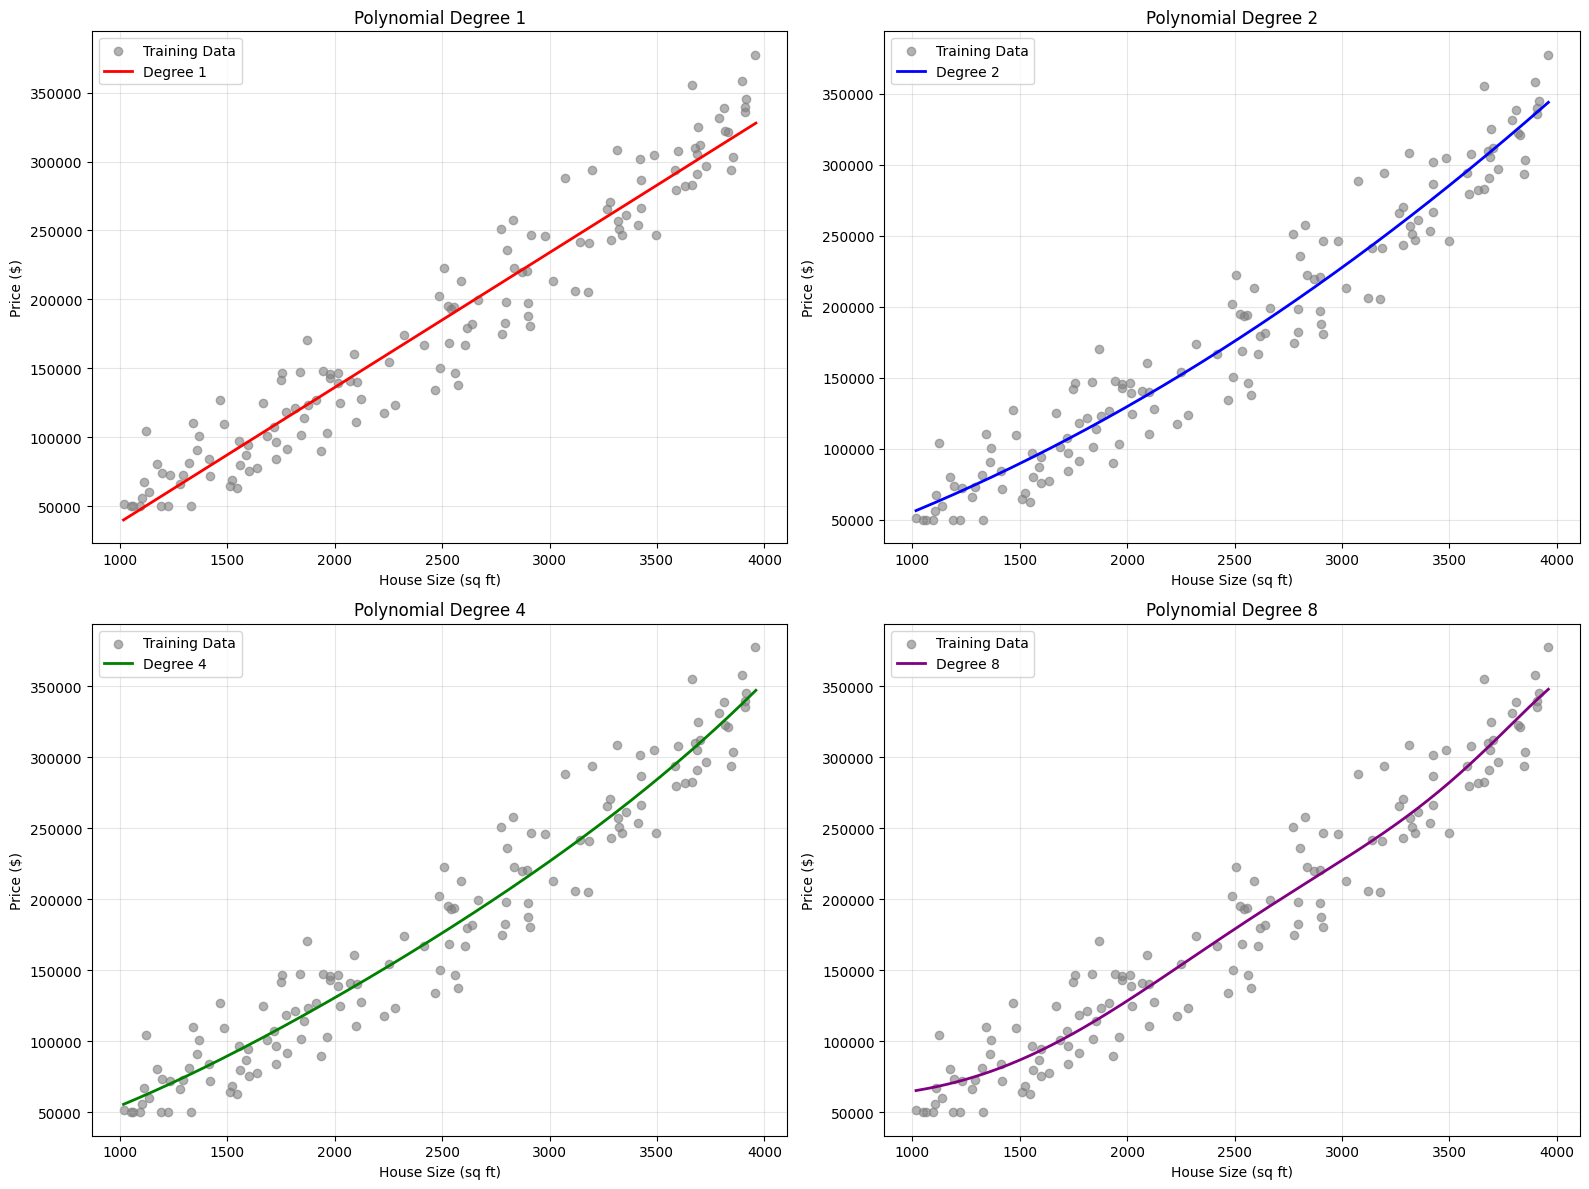

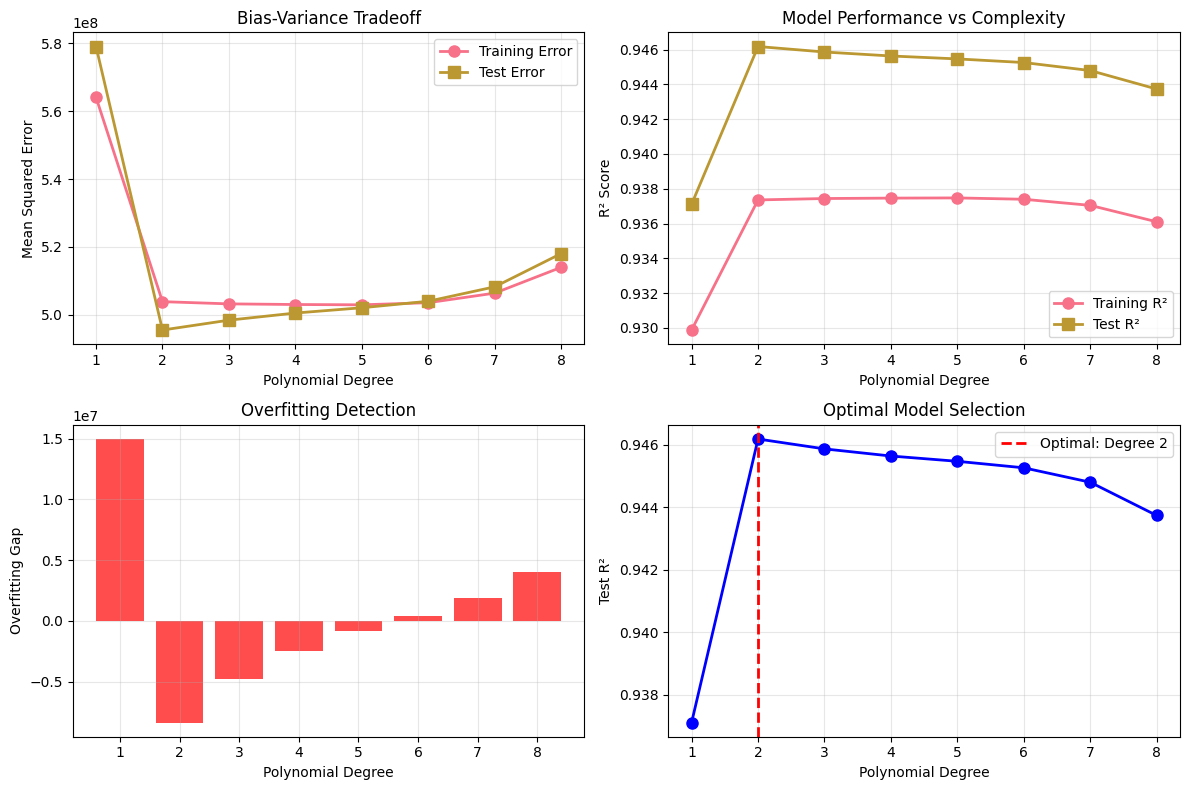

POLYNOMIAL REGRESSION INSIGHTS:
🔴 Underfitting (High Bias):

🟡 Overfitting (High Variance):
  • Degree 1: Gap = $14,959,281

✅ Sweet Spot: Degree 2
  • Test R²: 0.946
  • Overfitting: $-8,358,176


In [6]:
# Visualize polynomial regression curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Select specific degrees to visualize
viz_degrees = [1, 2, 4, 8]
colors = ['red', 'blue', 'green', 'purple']

for i, degree in enumerate(viz_degrees):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_simple)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_simple)
    
    # Create smooth curve for visualization
    X_plot = np.linspace(X_simple.min(), X_simple.max(), 300).reshape(-1, 1)
    X_plot_poly = poly_features.transform(X_plot)
    y_plot = model.predict(X_plot_poly)
    
    # Plot in different subplots
    row = i // 2
    col = i % 2
    
    axes[row, col].scatter(X_train_simple, y_train_simple, alpha=0.6, color='gray', label='Training Data')
    axes[row, col].plot(X_plot, y_plot, color=colors[i], linewidth=2, label=f'Degree {degree}')
    axes[row, col].set_xlabel('House Size (sq ft)')
    axes[row, col].set_ylabel('Price ($)')
    axes[row, col].set_title(f'Polynomial Degree {degree}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot the bias-variance tradeoff curve
plt.figure(figsize=(12, 8))

# Plot training and test error
plt.subplot(2, 2, 1)
plt.plot(poly_df['Degree'], poly_df['Train MSE'], 'o-', label='Training Error', linewidth=2, markersize=8)
plt.plot(poly_df['Degree'], poly_df['Test MSE'], 's-', label='Test Error', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R² scores
plt.subplot(2, 2, 2)
plt.plot(poly_df['Degree'], poly_df['Train R²'], 'o-', label='Training R²', linewidth=2, markersize=8)
plt.plot(poly_df['Degree'], poly_df['Test R²'], 's-', label='Test R²', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('Model Performance vs Complexity')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot overfitting gap
plt.subplot(2, 2, 3)
plt.bar(poly_df['Degree'], poly_df['Overfitting'], alpha=0.7, color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('Overfitting Gap')
plt.title('Overfitting Detection')
plt.grid(True, alpha=0.3)

# Highlight optimal degree
plt.subplot(2, 2, 4)
plt.plot(poly_df['Degree'], poly_df['Test R²'], 'o-', linewidth=2, markersize=8, color='blue')
plt.axvline(x=optimal_degree, color='red', linestyle='--', linewidth=2, label=f'Optimal: Degree {int(optimal_degree)}')
plt.xlabel('Polynomial Degree')
plt.ylabel('Test R²')
plt.title('Optimal Model Selection')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("POLYNOMIAL REGRESSION INSIGHTS:")
print("="*50)
print("🔴 Underfitting (High Bias):")
underfitting = poly_df[poly_df['Test R²'] < 0.3]
if len(underfitting) > 0:
    for _, row in underfitting.iterrows():
        print(f"  • Degree {int(row['Degree'])}: R² = {row['Test R²']:.3f}")

print("\n🟡 Overfitting (High Variance):")
overfitting = poly_df[poly_df['Overfitting'] > 5000000]
if len(overfitting) > 0:
    for _, row in overfitting.iterrows():
        print(f"  • Degree {int(row['Degree'])}: Gap = ${row['Overfitting']:,.0f}")

print(f"\n✅ Sweet Spot: Degree {int(optimal_degree)}")
print(f"  • Test R²: {poly_df.iloc[optimal_idx]['Test R²']:.3f}")
print(f"  • Overfitting: ${poly_df.iloc[optimal_idx]['Overfitting']:,.0f}")


## Key Takeaways

### **Understanding the Tradeoff:**
- **Bias**: Error from oversimplifying the model (underfitting)
- **Variance**: Error from model sensitivity to training data (overfitting)
- **Total Error = Bias² + Variance + Irreducible Error**

### **Model Selection Strategy:**
1. **Start simple** - Use basic models first
2. **Gradually increase complexity** - Add features or model complexity
3. **Monitor both training and test performance** - Watch for the gap
4. **Use cross-validation** - Get reliable performance estimates
5. **Stop when test performance degrades** - Find the sweet spot

### **Practical Guidelines:**
- **More data** can help** - Reduces variance, improves generalization
- **Regularization** - Helps balance bias and variance
- **Feature selection** - Remove irrelevant features to reduce variance
- **Ensemble methods** - Can help reduce both bias and variance

### **Red Flags to Watch:**
- **Large gap** between training and test performance = Overfitting
- **Poor performance** on both training and test = Underfitting
- **Unstable cross-validation** scores = High variance
- **Perfect training performance** with poor test performance = Overfitting
